In [19]:
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 3) Estaciones y Trayectos

## 3.0) Lectura y limpieza de datos

In [20]:
stations = pd.read_csv('../data/station.csv', low_memory=False)

stations.rename(columns={'installation_date':'date', 'long':'lon'}, inplace=True)

# Cambio el formato de las fechas
stations['date'] = pd.to_datetime(stations['date'])

In [21]:
trips = pd.read_csv('../data/trip.csv', low_memory=False)

#Eliminamos este dato ya que no sera relevante para estos analisis
trips.drop('zip_code', 1, inplace=True)

trips.rename(columns={'start_date'        :'s_date' , 
                      'end_date'          :'e_date' , 
                      'start_station_name':'ss_name', 
                      'start_station_id'  :'ss_id'  , 
                      'end_station_name'  :'es_name', 
                      'end_station_id'    :'es_id'  , 
                      'subscription_type' :'subs'
                     }, inplace=True)

# Cambio el formato de las fechas y tiempos de incio y fin de cada viaje
trips['s_date'] = pd.to_datetime(trips['s_date'], format='%m/%d/%Y %H:%M')
trips['e_date'] = pd.to_datetime(trips['e_date'], format='%m/%d/%Y %H:%M')

#Quitamos los viajes de duracion menor o igual a 3 minutos (180 segundos) y que de la misma estacion, 
#ya que pueden ser rutinas de mantenimiento o reparacion, etc
trips = trips[-((trips['duration'] <= 180) & (trips['ss_id'] == trips['es_id']))]
trips = trips[-(trips['duration'] > 28800)]

#Se ordenan los viajes por id
trips = trips.sort_values(by='id')

## 3.1) Suscriptores vs Clientes

Quienes utilizan mas el servicio? Suscriptores o clientes comunes?

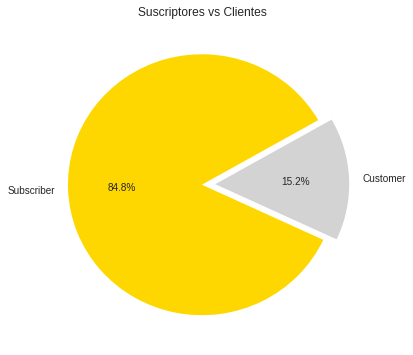

In [22]:
subs = trips.groupby('subs').count()[['id']]
lbls = subs.index.values
vals = subs.values

plt.figure(figsize=(6, 6))
plt.title('Suscriptores vs Clientes')
plt.pie(vals, explode=(0.1, 0), labels=lbls, colors=['lightgrey', 'gold'], autopct='%1.1f%%', startangle=-25)
plt.savefig('../img/suscriptores_vs_clientes.png')
plt.show()

Aqui se ve que la mayoria de los usuarios del servicio, estan suscriptos a este mismo. 

Esto puede indicar o refuerza la idea de que los usuarios del servicio, lo utilizan por necesidad y les es conveniente estar suscriptos.

## 3.2) 

In [23]:
trips_13_15 = trips
trips_2013 = trips['2014' > trips['s_date']].reset_index()
trips_2014 = trips[('2014' < trips['s_date']) & (trips['s_date'] < '2015')].reset_index()
trips_2015 = trips['2015' < trips['s_date']].reset_index()

viajes_por_anio = [trips_2013, trips_2014, trips_2015]
anios = ['2013', '2014', '2015']

#Calculamos la suma de bicicletas que partieron de las estaciones usadas en cada año
for i in range(len(viajes_por_anio)):
    viajes_por_anio[i]=viajes_por_anio[i].groupby('ss_name')['id'].count().sort_values(ascending=False)

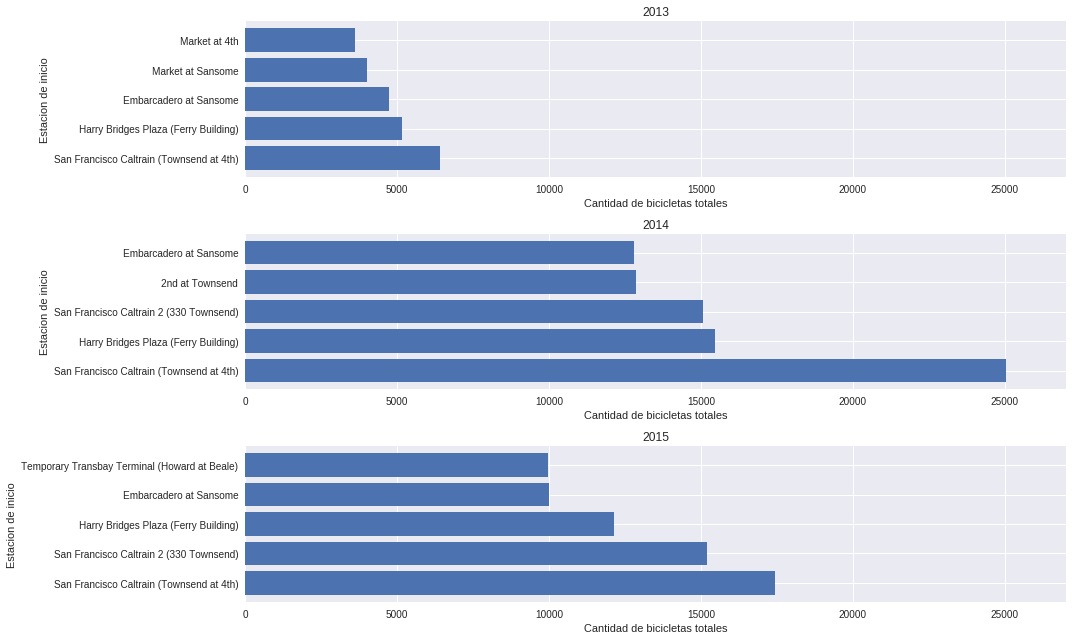

In [24]:
plt.figure(figsize=(15, 9))

for i in range(len(viajes_por_anio)):
    ax = plt.subplot(311 + i);
    ax.set_xlim([0, 25500])
    plt.title('Estaciones mas usadas en ' + anios[i]);
    plt.xlabel('Cantidad de bicicletas totales');
    plt.ylabel('Estacion de inicio');
    ax.barh([c for c in range(5)], 
            [c for c in viajes_por_anio[i][:5].values], 
            tick_label=[c for c in viajes_por_anio[i][:5].index.values])
    plt.savefig('../img/estaciones_mas_usadas_en_' + anios[i] + '.png')

plt.tight_layout()

Hay que tener en cuenta que del año 2013 estan registrados los viajes entre Agosto y Diciembre, y del año 2015 de Enero a Agosto, por ese motivo se registran menos cantidad de viajes en cada estacion.

Una observacion interesante es que, para los 7 u 8 meses registrados en 2015, la utilizacion del servicio, si bien es menor a la del año 2014 (12 meses), es parecida. Esto indica que ubo un aumento en la cantidad de viajes entre esos años.

## 3.3) Cantidad de viajes por Estación

In [25]:
from math import pi as PI

def distancia_grados(dist):
    return (180 * dist) / (6371 * PI)

def distancia_km(angulo):
    return angulo * 6371 * PI / 180

def mean(a, b):
    return (a + b) / 2

def mmap(value, min_in, max_in, min_out, max_out):
    m = (max_out - min_out) / float(max_in - min_in)
    b = min_out - m * min_in
    return m * value + b

In [26]:
#Calculamos la cantidad de bicicletas por cada estacion
bicis_por_estacion = trips.groupby('ss_id').count()[['ss_name']].reset_index()

bicis_por_estacion.rename(columns={'ss_id':'id', 'ss_name':'count'}, inplace=True)

#Agregamos el nombre de la estacion, la ciudad en donde queda y sus coordenadas
estaciones = pd.merge(stations.drop(['date', 'dock_count'], 1), bicis_por_estacion, on='id')

### 3.3.1) Frecuencia de uso de Estaciones por ciudad

Lo que se quiere ver ahora es, como se distribuyen los viajes realizados entre las estaciones de cada ciudad.
(se utiliza la cantidad de bicicletas que parten de una estacion como medida de frecuencia de uso de una estacion)

In [27]:
#Separamos las estaciones por ciudad
sf = estaciones[estaciones['city'] == 'San Francisco'].reset_index(drop=True)
sj = estaciones[estaciones['city'] == 'San Jose'     ].reset_index(drop=True)
mv = estaciones[estaciones['city'] == 'Mountain View'].reset_index(drop=True)
pa = estaciones[estaciones['city'] == 'Palo Alto'    ].reset_index(drop=True)
rc = estaciones[estaciones['city'] == 'Redwood City' ].reset_index(drop=True)

ciudades = [sf, sj, mv, pa, rc, estaciones]
nombres = ['San Francisco', 'San Jose', 'Mountain View', 'Palo Alto', 'Redwood City', 'Bahia']
ciudades_cant_estaciones = []
ciudades_bicis = []

#Listas con latitudes y longitudes de cada ciudad
lats = []
lons = []

offsets = []

#Para cada ciudad, vemos su cantidad de estaciones y la cantidad total de bicicletas
for ciudad in ciudades:
    ciudades_cant_estaciones.append(ciudad.shape[0])
    ciudades_bicis.append(ciudad['count'].sum())
    #Para mostrar a todas las estaciones, tomamos la media entre la coordenada maxima y minima
    lat_max, lat_min = ciudad['lat'].max(), ciudad['lat'].min()
    lon_max, lon_min = ciudad['lon'].max(), ciudad['lon'].min()
    lats.append(mean(lat_max, lat_min))
    lons.append(mean(lon_max, lon_min))
    offsets.append(max((lat_max - lat_min) * 0.6, (lon_max - lon_min) * 0.6))

#La cantidad de estaciones se va a utilizar para escalar a los tamaños de las estaciones en la visualizacion

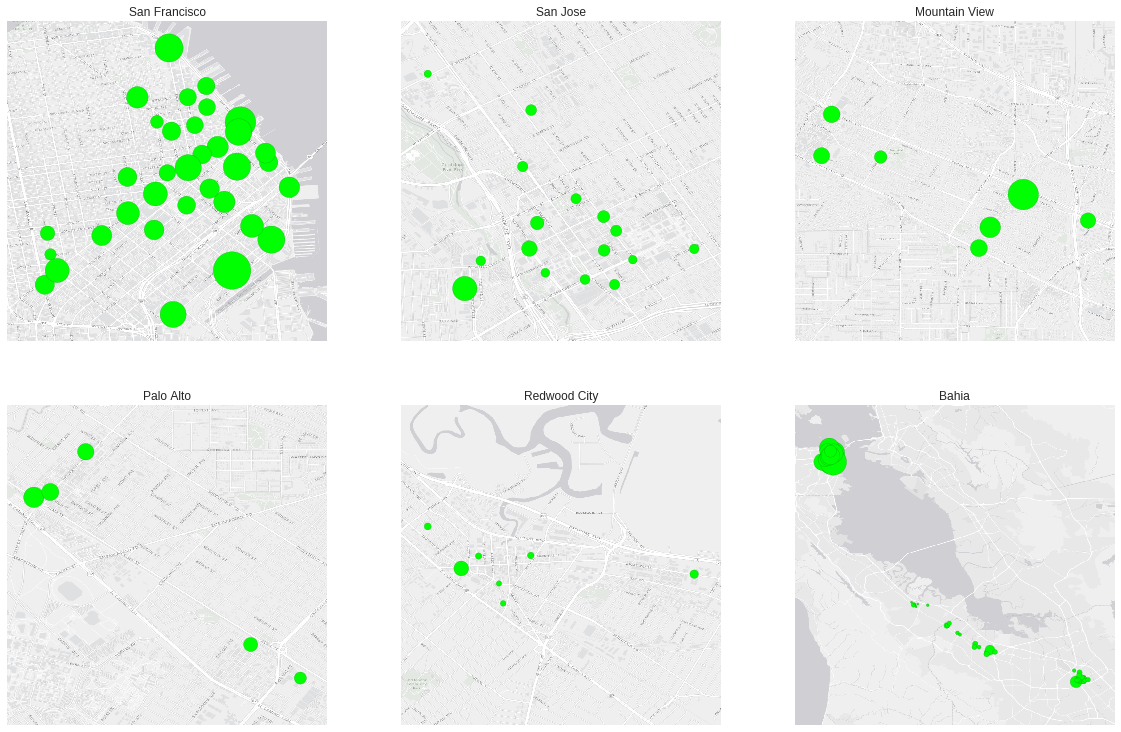

In [41]:
plt.figure(figsize=(20, 20))

for i in range(len(ciudades)):
    plt.subplot(331 + i);
    plt.title(nombres[i]);
    mapa=Basemap(projection='merc', resolution='i', epsg=4326, 
                 llcrnrlat=lats[i] - offsets[i], llcrnrlon=lons[i] - offsets[i], 
                 urcrnrlat=lats[i] + offsets[i], urcrnrlon=lons[i] + offsets[i])
    
    #Ploteamos las estaciones e indicamos frecuencia de uso
    #Aqui se escalan los tamaños de las estaciones dependiendo de la ciudad que se muestre
    mapa.scatter(ciudades[i]['lon'].values, ciudades[i]['lat'].values, marker='o', c='#00ff00', 
                 s=ciudades[i]['count'].apply(lambda x:x/ciudades_cant_estaciones[i]), edgecolors='#00aa00');
    
    mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, ypixels=1000);
    plt.savefig(nombres[i].lower().replace(' ','_') + '_estaciones_uso.png');

### 3.3.2) Concentración de viajes por ciudad

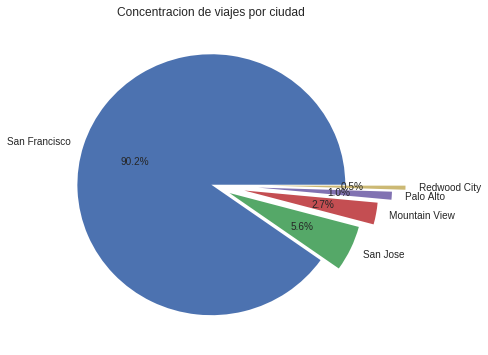

In [42]:
plt.figure(figsize=(6, 6))
plt.title('Concentracion de viajes por ciudad')
plt.pie(ciudades_bicis[:-1:], labels=nombres[:-1:], autopct='%1.1f%%', explode=(0, .15, .25, .35, .45))
plt.savefig('concentracion_viajes_por_ciudad.png')
plt.show()

Gran parte de los viajes parten de estaciones ubicadas en la ciudad de San Francisco. Luego le siguen San Jose, Mountain View, Palo Alto y por último Redwood City.

## 3.4) Trayectos mas frecuentes

### 3.4.1) Trayectos por ciudad

Lo que queremos lograr ahora es, ver cuales son los viajes entre estaciones mas utilizados.

Ademas de calcular los trayectos hay que juntar los que estan repetidos. Los trayectos con mas repeticiones seran considerados como los mas frecuentes.

In [31]:
trayectos_frec = trips[['id', 'ss_name', 'es_name']].groupby(['es_name', 'ss_name'], as_index=False).count()

trayectos_frec.rename(columns={'id':'count'}, inplace=True)

In [30]:
#Dataframe con los nombres de todas las estaciones y sus coordenadas
ss_location = stations[['name', 'lat', 'lon', 'city']]
ss_location.rename(columns={'name':'ss_name', 'lat':'s_lat', 'lon':'s_lon', 'city':'s_city'}, inplace=True)

es_location = stations[['name', 'lat', 'lon', 'city']]
es_location.rename(columns={'name':'es_name', 'lat':'e_lat', 'lon':'e_lon', 'city':'e_city'}, inplace=True)

#Estos dataframes seran combinados con los de trayectos por la columna que tengan en comun
#En este caso, se quiere obtener un dataframe con 2 estaciones (inicial y final) con sus coordenadas y viajes

/home/mk/datos/benv/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [32]:
def reducir_trayectos(trayectos_frec):
    #El trayecto A -> B es el mismo que B -> A
    #Esta funcion junta las repeticiones de estos trayectos
    l = [] 
        #Lista con indice del dataframe del trayecto eliminado
    for i in range(len(trayectos_frec)):
            #Por cada trayecto
        if i not in l:
            #Si esta en el dataframe
            prim = trayectos_frec.loc[i]
                #Obtenemos el trayecto actual
            for j in range(i, len(trayectos_frec)):
                #Buscamos en lo que resta del dataframe
                if j not in l:
                    #Si el trayecto que queremos ver, esta en el dataframe
                    seg = trayectos_frec.loc[j] 
                        #Lo guardamos
                    if prim['ss_name'] == seg['es_name'] and prim['es_name'] == seg['ss_name']:
                        #Si coinciden los trayectos
                        trayectos_frec.loc[i]['count'] += trayectos_frec.loc[j]['count']
                            #Sumamos los trayectos
                            #Nosotros consideramos que los trayectos de A a B son iguales que los de B a A
                            #Pero en el dataframe no estan asi, por eso sumamos los viajes
                        trayectos_frec.drop(j, inplace=True)
                            #Quitamos al segundo trayecto del dataframe
                        l.append(j)
                            #Lo colocamos en la lista, para que no halla error luego
    return trayectos_frec

tf = reducir_trayectos(trayectos_frec)

# Añadimos al dataframe, las ubicaciones de cada estacion
tf = pd.merge(tf, ss_location, on='ss_name')
tf = pd.merge(tf, es_location, on='es_name')

/home/mk/datos/benv/lib/python2.7/site-packages/ipykernel/__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
#Este diccionario se va a contener, por ciudad:
#    . lista de tuplas ([lons], [lats], color) que tienen las coord de estaciones de un trayecto y su color
#    . lista de los trayectos de la ciudad
viajes = {'San Francisco':[[], []], 
          'San Jose'     :[[], []], 
          'Redwood City' :[[], []], 
          'Mountain View':[[], []], 
          'Palo Alto'    :[[], []]
         }

for ciudad in viajes:
    #Filtramos los trayectos por ciudad
    #Aqui se quitan los trayectos con estaciones en distintas ciudades
    viajes[ciudad][1] = tf[(tf['s_city'] == ciudad) & \
                           (tf['e_city'] == ciudad)].drop(['s_city', 'e_city'], 1).reset_index(drop=True)
    
    #Calculamos la cantidad maxima de viajes por cada trayecto en cada ciudad
    #Esto es para luego asignar colores a trayectos con mas o menos frecuencia
    max_val = 0
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        if trayecto['count'] > max_val:
            max_val = trayecto['count']
    
    #Colocamos longitud y latitud de un trayecto ademas de su frecuencia convertida a un numero en [0;255]
    for indice in range(len(viajes[ciudad][1])):
        trayecto = viajes[ciudad][1].loc[indice]
        #Mapeo de la frecuencia del trayecto al intervalo [0;255]
        color = int(mmap(trayecto['count'], 0, max_val, 0, 255))
        color = abs(255 - color)
        viajes[ciudad][0].append(([trayecto['s_lon'], trayecto['e_lon']], 
                                  [trayecto['s_lat'], trayecto['e_lat']], 
                                  color))
        
    #Ordenamos los viajes mas frecuentes al final, 
    #asi son mostrados por encima de los trayectos menos frecuentes
    viajes[ciudad][0].sort(key=lambda x:-x[2])

/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/mk/datos/benv/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


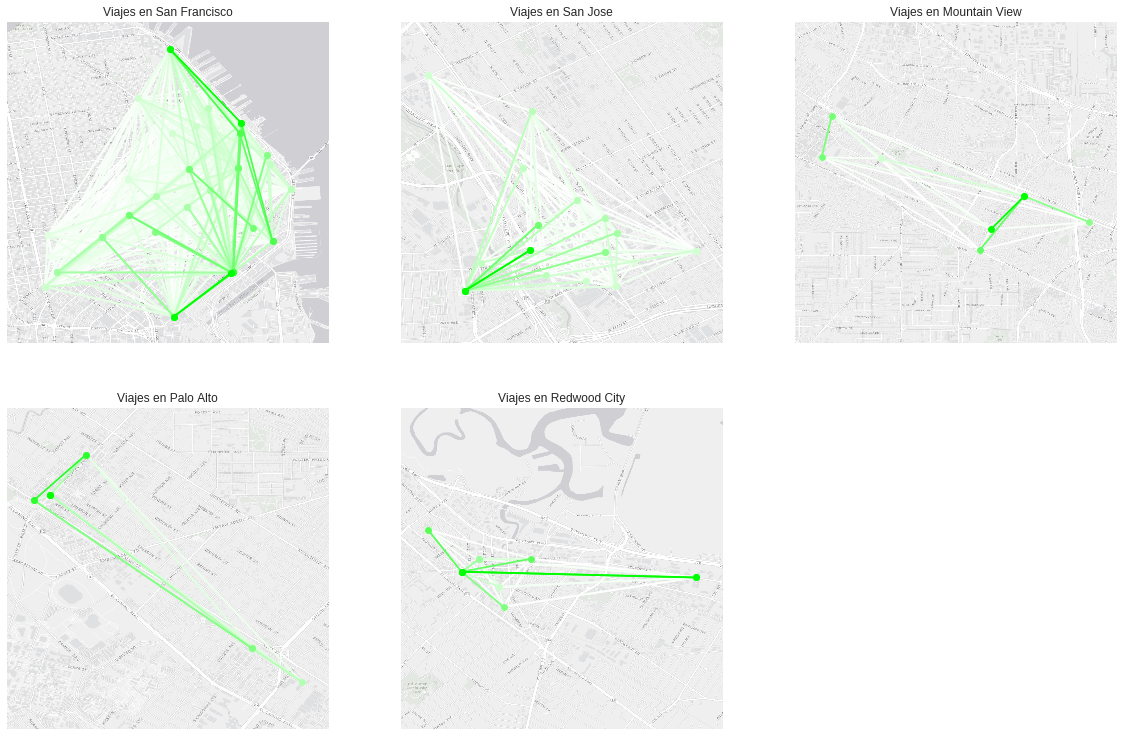

In [34]:
#Ahora visualizamos los trayectos por ciudad
plt.figure(figsize=(20, 13))

for i in range(len(ciudades)-1):
    plt.subplot(231 + i);
    plt.title('Viajes en ' + nombres[i]);
    mapa = Basemap(projection='merc', resolution='i', epsg=4326, 
                   llcrnrlat=lats[i] - offsets[i], llcrnrlon=lons[i] - offsets[i], 
                   urcrnrlat=lats[i] + offsets[i], urcrnrlon=lons[i] + offsets[i])
    
    for trayecto in viajes[nombres[i]][0]:
        #Convertimos el color a un formato RGBA valido
        color = trayecto[2]
        color = '#%02Xff%02X' % (color, color)
        #Ploteamos el trayecto
        mapa.plot(trayecto[0], trayecto[1], 'o-', color=color)

    mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, ypixels=1000);
    plt.savefig(nombres[i].lower().replace(' ','_') + '_frecuencia_trayectos.png');

### 3.4.2) Trayectos de toda la bahia

In [ ]:
plt.figure(figsize=(15, 15))
plt.title('Viajes en toda la Bahia')

offset = distancia_grados(35)
mapa = Basemap(projection='merc', resolution='i', epsg=4326, 
               llcrnrlat=lats[5] - offset, llcrnrlon=lons[5] - offset, 
               urcrnrlat=lats[5] + offset, urcrnrlon=lons[5] + offset )

max_val = tf['count'].max()
tf = tf.sort_values(by='count').reset_index(drop=True)

for indice in range(tf.shape[0]):
    trayecto = tf.loc[indice]
    color = int(mmap(trayecto['count'], 0, max_val, 0, 255))
    color = abs(255 - color)
    mapa.plot([trayecto['s_lon'], trayecto['e_lon']], 
              [trayecto['s_lat'], trayecto['e_lat']], 
              'o-', color='#%02Xff%02X' % (color, color))

mapa.arcgisimage(service='Canvas/World_Light_Gray_Base', xpixels=1000, ypixels=1000);
plt.show()

## 3.5) Cuál es la cantidad total de bicicletas que se utilizó?

### 3.5.1) Cantidad de bicicletas en total

In [36]:
#Se cuentan los valores para cada id de bicicleta diferente
trips['bike_id'].value_counts().count()

700

El total de bicicletas diferentes es de 700. Tener en cuenta que esta cantidad de bicicletas que se registraron en todos los datos, eso incluye los diferentes periodos de cada año (2013 4 o 5 meses, 2014 todo el año y 2015 7 u 8 meses). 

Entonces lo que indica el numero, fue la cantidad de bicicletas que estuvieron en servicio.

A continuacion vemos la cantidad de bicicletas diferentes que estaban disponibles por mes. Ojo, esta es una cota inferior, porque se analizan los datos de viajes realizados, que no dice cuantas bicicletas estaban disponibles.

### 3.5.2) Cantidad de bicicletas utilizadas por mes

In [83]:
trips_fechas = trips[['s_date', 'bike_id', 'id']].reset_index(drop=True)
trips_fechas['s_date'] = pd.to_datetime(trips_fechas['s_date'].dt.strftime('%Y-%m'))

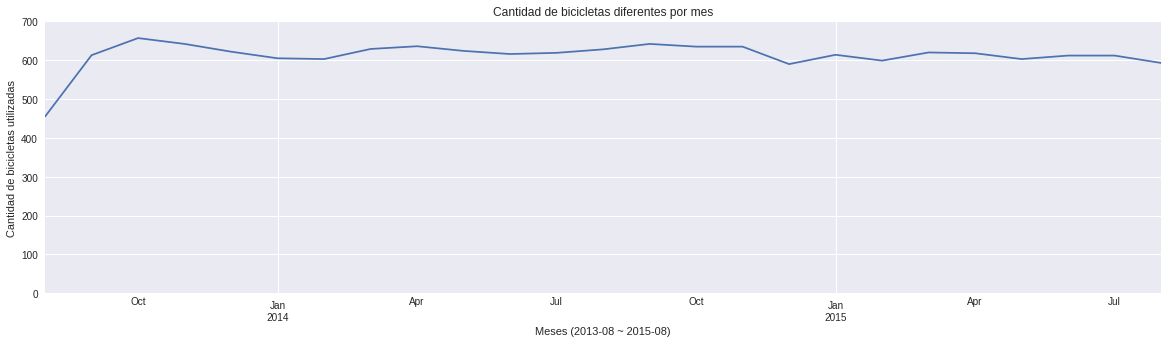

In [87]:
trips_fechas.groupby(['s_date', 'bike_id'], as_index=False).count()\
            .groupby('s_date')['bike_id'].count().plot.line(figsize=(20, 5), ylim=(0, 700));
plt.title('Cantidad de bicicletas diferentes por mes');
plt.xlabel('Meses (2013-08 ~ 2015-08)');
plt.ylabel('Cantidad de bicicletas utilizadas');

En el grafico se ve que la cantidad de bicicletas utilizadas es menor a 700, es decir no siempre se utilizan todas las bicicletas.